In [1]:
import time
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import os

# Initialize weights and bias 
def weight_variable(name, shape_in):
    return tf.get_variable(name,shape=shape_in, initializer=tf.contrib.layers.xavier_initializer())

def bias_variable(name, shape_in):
    return tf.get_variable(name,shape=shape_in, initializer=tf.contrib.layers.xavier_initializer())

In [2]:
data1 = scipy.io.loadmat('data/dataset.mat')
data2 = scipy.io.loadmat('data/dataset2.mat')

data_x = np.concatenate([data1['X'], data2['X']], axis = 0)
data_y = np.concatenate([data1['Y'], data2['Y']], axis = 0)

normalization_factor = [1.0/5, 1.0/5, 1.0/20, 1.0/20, 1.0, 1.0]
normalization_bias = [0.0, 0, 0, 0, 0, 0]

data_x[:,4,:] = 1/data_x[:,4,:]
data_y[:,4,:] = 1/data_y[:,4,:]
data_x[:,5,:] = 1/data_x[:,5,:]
data_y[:,5,:] = 1/data_y[:,5,:]
data_x[:,4,5] = 0
data_y[:,4,5] = 0
data_x[:,5,5] = 0
data_y[:,5,5] = 0

for i in range(len(normalization_factor)):
    data_x[:,i,:] = data_x[:,i,:] * normalization_factor[i] + normalization_bias[i]
    data_y[:,i,:] = data_y[:,i,:] * normalization_factor[i] + normalization_bias[i]

print(np.shape(data_x), np.shape(data_y))

print(data_x[0,5,:])
print(data_y[0,5,:])


(500000, 6, 6) (500000, 6, 6)
[0.66666667 1.         1.         1.24999998 0.8333333  0.        ]
[0.66666667 1.         1.         1.24999998 0.8333333  0.        ]


In [3]:
tf.reset_default_graph()

sess = tf.InteractiveSession()


object_state = np.shape(data_x)[-2]
object_num = np.shape(data_x)[-1]
# object_num = 1

relation_num = 30
relation_state = 1

external_num = 1

object_input = tf.placeholder(tf.float32, [None, object_state, object_num])

loss_state_num = 4

y = tf.placeholder(tf.float32, [None, loss_state_num, object_num])

input_flatten = tf.reshape(object_input, [-1, object_state*object_num])

w1 = weight_variable('w1', [object_state*object_num, 1000])
b1 = weight_variable('b1', [1000])
w2 = weight_variable('w2', [1000, 1000])
b2 = weight_variable('b2', [1000])
w3 = weight_variable('w3', [1000, 1000])
b3 = weight_variable('b3', [1000])

w4 = weight_variable('w4', [1000, loss_state_num*object_num])
b4 = weight_variable('b4', [loss_state_num*object_num])

h1 = tf.nn.relu(tf.matmul(input_flatten, w1) + b1)
h2 = tf.nn.relu(tf.matmul(h1, w2) + b2)
h3 = tf.nn.relu(tf.matmul(h2, w3) + b3)
h4 = tf.matmul(h3, w4) + b4

predictions = tf.reshape(h4, [-1, loss_state_num, object_num])

print(predictions)

loss = tf.reduce_mean(tf.reduce_mean(tf.reduce_mean(tf.square(y - predictions), axis = 1), axis = 1)) + 1

print(loss.get_shape())

lr = tf.placeholder(tf.float32)

train_step = tf.train.AdamOptimizer(lr).minimize(loss)

sess.run(tf.global_variables_initializer())

Instructions for updating:
Use the retry module or similar alternatives.
Tensor("Reshape_1:0", shape=(?, 4, 6), dtype=float32)
()


In [4]:


batch_size = 256
epoch_num = 5

train_data_num = np.shape(data_x)[0]

for epoch in range(epoch_num):
    order = np.arange(train_data_num)
    np.random.shuffle(order)
    temp_train_x = data_x[order]
    temp_train_y = data_y[order]
    for batch_step in range(int(train_data_num/batch_size)+1):
        batch_idx = [batch_step*batch_size, (batch_step+1)*batch_size]
        if batch_idx[1] > train_data_num: batch_idx[1] = train_data_num
        
        batch_x = temp_train_x[batch_idx[0]:batch_idx[1]]
        batch_y = temp_train_y[batch_idx[0]:batch_idx[1]]
        batch_y = batch_y[:,0:loss_state_num,:]

                    
        train_step.run(feed_dict={object_input: batch_x, y: batch_y,lr: 0.000001})
        loss_value = loss.eval(feed_dict={object_input: batch_x, y: batch_y})
        print_num = int((batch_step/(int(train_data_num/batch_size)+1))*30)
        print_string = "epoch %d/%d, ["%(epoch+1,epoch_num)+"="*print_num+" "*(30-print_num) +"] loss = "+"%g"%(loss_value)
        print(print_string, end="\r")
        
#         print(relation_check)
#         print(batch_Rs[0,:,:])
#         print('\n')
#         print(batch_Rr[0,:,:])        
#         print(np.shape(batch_x),np.shape(batch_y))
    
    sample = 2048
    temp_loss=np.zeros([int(train_data_num/sample)+1])
    for batch_step in range(int(train_data_num/sample)+1):
        start = batch_step*sample
        end = (batch_step+1)*sample
        if end > train_data_num:
            end = train_data_num
            
        batch_x = temp_train_x[start:end]
        batch_y = temp_train_y[start:end]
        batch_y = batch_y[:,0:loss_state_num,:]

        loss_value = loss.eval(feed_dict={object_input: batch_x, y: batch_y})
        temp_loss[batch_step] = loss_value * (end - start)
        # print("temp accuracy %g"%temp_temp)
    temp_loss = np.sum(temp_loss)/train_data_num
    
    print("\nepoch %d/%d, loss= %g"%(epoch+1, epoch_num, temp_loss))
    

epoch 1/5, [============================= ] loss = 1.05117
epoch 1/5, loss= 1.05301
epoch 2/5, [============================= ] loss = 1.00916
epoch 2/5, loss= 1.01001
epoch 3/5, [============================= ] loss = 1.00365
epoch 3/5, loss= 1.00358
epoch 4/5, [============================= ] loss = 1.00192
epoch 4/5, loss= 1.00253
epoch 5/5, [============================= ] loss = 1.00162
epoch 5/5, loss= 1.0024


In [5]:
print(tf.trainable_variables(scope=None))

[<tf.Variable 'w1:0' shape=(36, 1000) dtype=float32_ref>, <tf.Variable 'b1:0' shape=(1000,) dtype=float32_ref>, <tf.Variable 'w2:0' shape=(1000, 1000) dtype=float32_ref>, <tf.Variable 'b2:0' shape=(1000,) dtype=float32_ref>, <tf.Variable 'w3:0' shape=(1000, 1000) dtype=float32_ref>, <tf.Variable 'b3:0' shape=(1000,) dtype=float32_ref>, <tf.Variable 'w4:0' shape=(1000, 24) dtype=float32_ref>, <tf.Variable 'b4:0' shape=(24,) dtype=float32_ref>]


[[[-0.03005981  0.15432284 -0.34418204  0.52234626 -0.41993952
    0.        ]
  [ 0.22763882 -0.57479115  0.03169031 -0.36189108 -0.54110451
    0.        ]
  [-0.17974668 -0.16294408  0.03535991  0.30461397 -0.34212151
    0.        ]
  [-0.21508799  0.15164622  0.17765149 -0.038905    0.22079821
    0.        ]
  [ 0.66666667  1.          1.          1.24999998  0.8333333
    0.        ]
  [ 0.66666667  1.          1.          1.24999998  0.8333333
    0.        ]]

 [[-0.04443955  0.14128731 -0.34135325  0.54671535 -0.44730926
    0.        ]
  [ 0.21043177 -0.56265945  0.04590243 -0.36500349 -0.52344065
    0.        ]
  [-0.17974668 -0.16294408  0.03535991  0.30461397 -0.34212151
    0.        ]
  [-0.21508799  0.15164622  0.17765149 -0.038905    0.22079821
    0.        ]
  [ 0.66666667  1.          1.          1.24999998  0.8333333
    0.        ]
  [ 0.66666667  1.          1.          1.24999998  0.8333333
    0.        ]]

 [[-0.05881928  0.12825179 -0.33852446  0.57108445 -

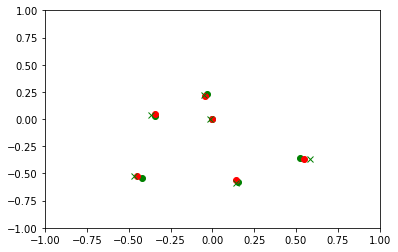

In [6]:
plt.figure(1)
test_idx = 0000

batch_x = data_x[test_idx:(test_idx+5)]
batch_y = data_y[test_idx:(test_idx+5)]
batch_y = batch_y[:,0:loss_state_num,:]

print(batch_x)
pred = predictions.eval(feed_dict={object_input: batch_x, y: batch_y})
print(pred)
plt.plot(data_x[test_idx,0,:], data_x[test_idx,1,:], 'go')
plt.plot(data_y[test_idx,0,:], data_y[test_idx,1,:], 'ro')
plt.plot(pred[0,0,:], pred[0,1,:], 'gx')
plt.axis([-1, 1, -1, 1])
plt.show()